In [3]:
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import fitstools
from pathlib import PurePath
import glob
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from astropy.io.fits import getheader
from balltracking import mballtrack as mblt
from skimage.feature import peak_local_max
# from cython_modules import interp

plt.rcParams.update({'font.size': 12})
dpi = 168

DTYPE = np.float32
def prep_data(image):
    image2 =np.abs(image)
    image3 = image2.max() - image2
    surface = (image3 - image3.mean())/image3.std()
    return surface.copy(order='C').astype(DTYPE)

%matplotlib widget

In [26]:
# Data prepped by COR2_tracking_prep.ipynb
datadir = PurePath('C:\Data\STEREO\L7tum\prep_fits')
outputdir = PurePath('C:\Data\STEREO\L7tum\\figures')
datafiles = sorted(glob.glob(str(PurePath(datadir, '*.fits'))))
nfiles = len(datafiles)
nsamples = 80
fov = np.s_[0:659, 0:600]

nballs_max = 197700


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
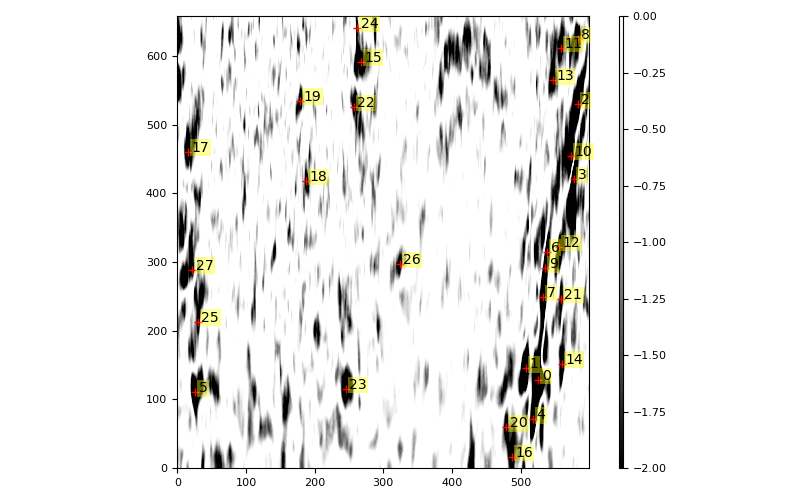

In [27]:
plt.close('all')
mbt_dict = {"nt":80,
            "rs":4,
            "am":1,
            "dp":0.3,
            "tdx":1,
            "tdy":100,
            "zdamping":1,
            "ballspacing":15,
            "intsteps":20,
            "mag_thresh":3.5,
            "noise_level":2,
            "track_emergence":False,
            "prep_function":prep_data,
            "datafiles":datafiles,
            "fov":fov,
            "do_plots":False,
            "astropy":True,
            "verbose":False,
            "outputdir":datadir,
            "fig_dir":PurePath(datadir, 'figures')}

# mbt_p, mbt_n = mblt.mballtrack_main(**mbt_dict)

mbt = mblt.MBT(polarity=1, **mbt_dict)


fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
im = axs.imshow(mbt.surface, vmin = -2, vmax=0, origin='lower', cmap='Greys_r')
# position for the colorbar
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='1%', pad=0.3)
# Adding the colorbar
cbar = plt.colorbar(im, cax = cax)

axs.plot(mbt.xstart, mbt.ystart, 'r+')
labels = np.arange(0, mbt.nballs)
labels_str = [str(l) for l in labels]
for i, l in enumerate(labels_str):
    axs.text(mbt.xstart[i]+5, mbt.ystart[i], l, color='black', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.4, edgecolor='none', pad=1))

plt.tight_layout()
# bmask = mbt.ystart <= 300
# axs.plot(mbt.xstart[bmask], mbt.ystart[bmask], 'co', ms=10, markerfacecolor='none')

In [29]:
select_balls = [5, 25, 23, 26, 16, 20, 0, 1, 14]
init_pos = np.array([mbt.xstart, mbt.ystart, mbt.zstart])[:, select_balls]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
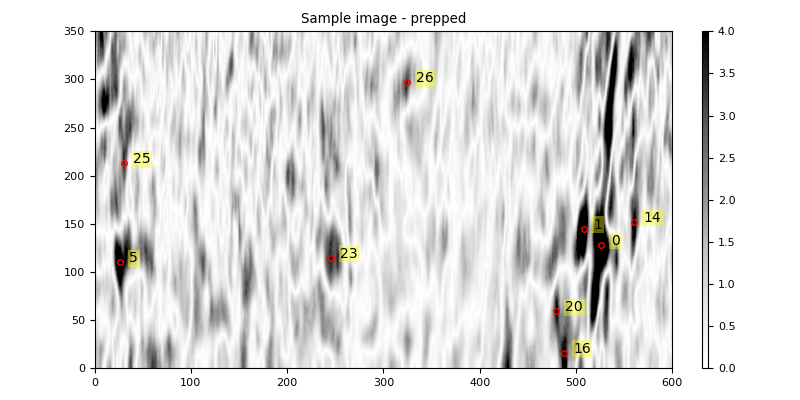

In [32]:
sample = np.abs(fitstools.fitsread(datafiles[0], cube=False, astropy=True))
vmin = 0
vmax = 4

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8,4))
im = axs.imshow(sample, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys')
# position for the colorbar
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='1%', pad=0.3)
# Adding the colorbar
cbar = plt.colorbar(im, cax = cax)
axs.set_xlim([0, 600])
axs.set_ylim([0, 350])
axs.set_title('Sample image - prepped')

axs.plot(init_pos[0, :], init_pos[1, :], 'ro', ms=4, markerfacecolor='none')
for j, ball in enumerate(select_balls):
    axs.text(init_pos[0, j]+10, init_pos[1, j], str(ball), color='black', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.4, edgecolor='none', pad=1))

plt.tight_layout()

In [33]:
plt.close('all')
mbt_dict = {"nt":30,
            "rs":4,
            "am":2,
            "dp":0.3,
            "tdx":1,
            "tdy":100,
            "zdamping":1,
            "ballspacing":15,
            "intsteps":30,
            "mag_thresh":3.5,
            "noise_level":1,
            "track_emergence":False,
            "prep_function":prep_data,
            "datafiles":datafiles,
            "fov":fov,
            "init_pos":init_pos,
            "do_plots":False,
            "astropy":True,
            "verbose":False,
            "outputdir":datadir,
            "fig_dir":PurePath(datadir, 'figures')}

mbt = mblt.MBT(polarity=1, **mbt_dict)

nballs_max = 9


In [34]:
mbt.track_all_frames()

Tracking with 9 initial balls
Total number of balls used self.nballs = 9


Show ball positions & local maxima at the next frame(s) 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
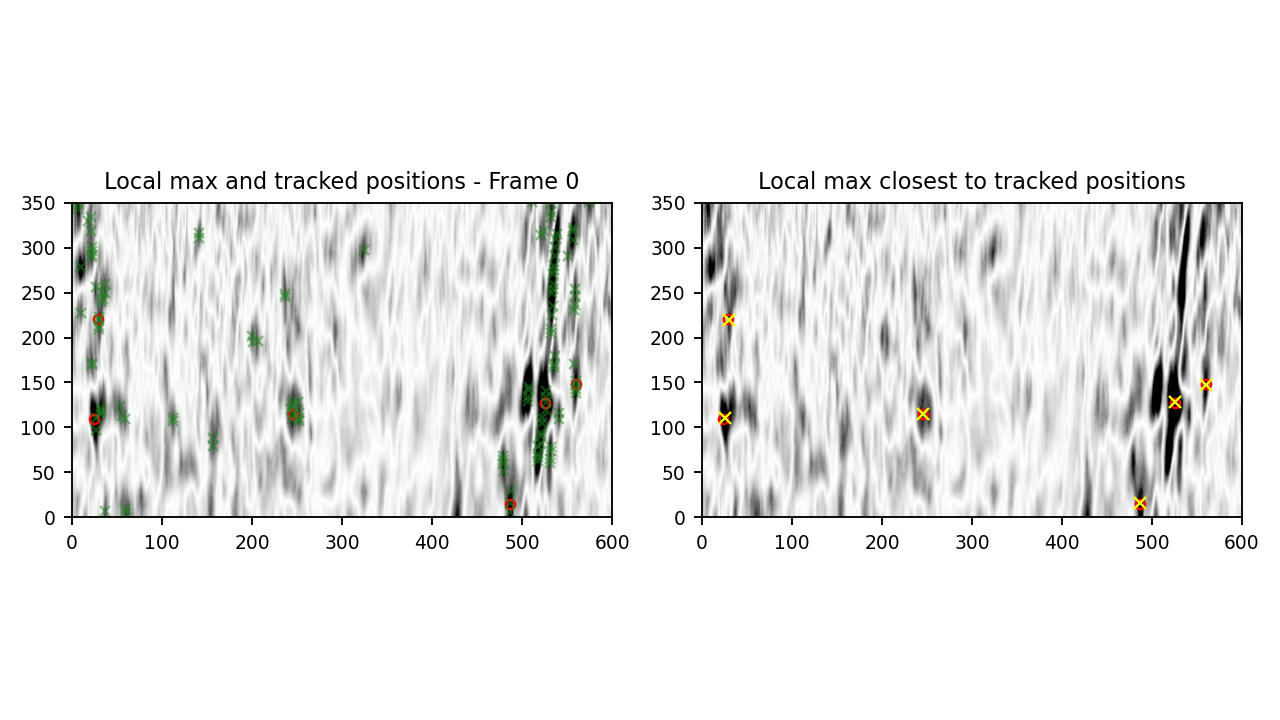

In [25]:
plt.close('all')
plt.rcParams.update({'font.size': 8})
ballpos = mbt.ballpos.copy()
ballpos[ballpos == -1] = np.nan
for n in range(0, 1):

    sample = np.abs(fitstools.fitsread(datafiles[n], cube=False, astropy=True))
    ymax, xmax = peak_local_max(np.abs(sample), min_distance=2, threshold_abs=3).T
    # Get distances with closest peaks
    distance_matrix = np.sqrt((xmax[:,np.newaxis] - ballpos[0, :, n][np.newaxis,:])**2 + (ymax[:,np.newaxis] - ballpos[1, :, n][np.newaxis,:])**2)
    distance_min = distance_matrix.min(axis=0)
    close_max_inds = distance_matrix.argmin(axis=0)
    close_max = np.array((xmax[close_max_inds], ymax[close_max_inds]))


    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(1280/dpi, 720/dpi), dpi=dpi)
    axs[0].imshow(sample, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys')
    
    # Plot balls
    axs[0].plot(ballpos[0, :, n], ballpos[1, :, n], 'ro', ms=4, markerfacecolor='none', label='ball position')
    # Plot local max
    axs[0].plot(xmax, ymax, marker='x', ls='none', color='forestgreen', ms=4, label='local max', alpha=0.5)
    
    axs[0].set_xlim([0, 1000])
    axs[0].set_ylim([0, 350])
    axs[0].set_title(f'Local max and tracked positions - Frame {n}')

    axs[1].imshow(sample, vmin=vmin, vmax=vmax, origin='lower', cmap='Greys')
    # Plot balls
    axs[1].plot(ballpos[0, :, n], ballpos[1, :, n], 'ro', ms=4, markerfacecolor='none', label='ball position')
    # Plot local max
    axs[1].plot(close_max[0,:], close_max[1,:], marker='x', ls='none', color='yellow', ms=5, label='local max')

    axs[1].set_xlim([0, 600])
    axs[1].set_ylim([0, 350])
    axs[1].set_title(f'Local max closest to tracked positions')

    plt.tight_layout()
    
    # fig.savefig(PurePath(outputdir, f'Zoom_Balltrack_closest_local_max_L7tum_{n:04d}.jpg'), dpi=dpi) #
    # plt.close()

In [ ]:
a = np.zeros([10, 10])
r = np.s_[0:3, 0:4]
a[r]